# Physics Informed Neural Networks (PINNS)

In [1]:
import torch
import numpy as np
import time
import sys

# Define the random seed for reproductibility
np.random.seed(1234)
torch.manual_seed(1234)

# Check if we run on GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Running on {device}. Have fun!")

Running on cpu. Have fun!


In [2]:
# PDE configurations
a1 = 2
a2 = 1
k  = 1

## Definition of the domain

In [3]:
# Data
## Domain bounds
x_bound_low = -1
x_bound_up  =  1
y_bound_low = -1
y_bound_up  =  1
bounds = [x_bound_low, x_bound_up, y_bound_low, y_bound_up]

## Test points
num_test_x =  120
num_test_y =  120
X, Y       = np.meshgrid(np.linspace(x_bound_low,x_bound_up,num_test_x), np.linspace(y_bound_low,y_bound_up,num_test_y))
Test_exact = (np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)).flatten()[:,None]  # Exact solution
X_test     = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))                # Test points

## Define a Random Uniform sampler on the domain

In [4]:
def RandomSampling(Ncollocation, Nbounds, bounds):
    ## Collocation points, inside domain for training
    x = np.random.uniform(bounds[0], bounds[1], Ncollocation)
    y = np.random.uniform(bounds[2], bounds[3], Ncollocation)
    X_f_train = np.hstack((x.flatten()[:,None], y.flatten()[:,None]))
    
    ## Boundaries
    ### boundaries up and down
    x_bc_u = np.random.uniform(bounds[0], bounds[1], Nbounds)
    y_bc_u = np.full(Nbounds, bounds[3])
    x_bc_d = np.random.uniform(bounds[0], bounds[1], Nbounds)
    y_bc_d = np.full(Nbounds, bounds[2])
    ### boundaries left and right
    y_bc_l = np.random.uniform(bounds[2], bounds[3], Nbounds)
    x_bc_l = np.full(Nbounds, bounds[0])
    y_bc_r = np.random.uniform(bounds[2], bounds[3], Nbounds)
    x_bc_r = np.full(Nbounds, bounds[1])

    X_star = np.hstack((np.vstack([x_bc_u,x_bc_d,x_bc_l,x_bc_r]).flatten()[:,None], np.vstack([y_bc_u,y_bc_d,y_bc_l,y_bc_r]).flatten()[:,None]))
    return X_f_train, X_star

## Collocation points for the training

In [5]:
## Train points
Ncollocation      = 1024
Nbounds           =  256
X_f_train, X_star = RandomSampling(Ncollocation, Nbounds, bounds)
Exact_bc          = np.zeros(X_star.shape[0]).flatten()[:,None]
lb                = X_star.min(0)
ub                = X_star.max(0)


## Experimental points, completely made up
nPtsExp   = 50
yExp1     = np.random.uniform(bounds[2], bounds[3], nPtsExp)
xExp1     = np.full(nPtsExp, 0.25)
yExp2     = np.random.uniform(bounds[2], bounds[3], nPtsExp)
xExp2     = np.full(nPtsExp, 0.5)
yExp3     = np.random.uniform(bounds[2], bounds[3], nPtsExp)
xExp3     = np.full(nPtsExp, 0.75)
X_exp     = np.hstack((np.vstack([xExp1,xExp2,xExp3]).flatten()[:,None], np.vstack([yExp1,yExp2,yExp3]).flatten()[:,None]))
Exp_exact = (np.sin(a1 * np.pi * X_exp[:,0:1]) * np.sin(a2 * np.pi * X_exp[:,1:2])).flatten()[:,None]  # Exact solution, can be fun to add noise

test_a1 = np.array([1.1])
test_a2 = np.array([0.2])

In [6]:
class FCN(torch.nn.Module):
    
    def __init__(self, X_bc, U_bc, X_f, X_test, U_exact, X_exp, U_exp, layers, lb, ub, a1, a2, k, device):
        super().__init__() 
        # bounds
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        # data
        ## Boundaries
        self.X_bc = torch.tensor(X_bc, requires_grad=True).float().to(device)  # Boundary points
        self.U_bc = torch.tensor(U_bc).float().to(device)                      # Field Value at boundary

        ## Domain, collocation points'
        self.x        = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device) 
        self.y        = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.f_target = torch.zeros(X_f.shape[0],1).to(device)

        ## Experimental points
        self.X_exp = torch.tensor(X_exp, requires_grad=False).float().to(device)
        self.U_exp = torch.tensor(U_exp, requires_grad=False).float().to(device)

        ## Test
        self.X_test  = torch.tensor(X_test , requires_grad=False).float().to(device) # Test points
        self.U_exact = torch.tensor(U_exact, requires_grad=False).float().to(device) # Exact value

        # PDE parameters
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        self.k  = k
        self.a1 = torch.nn.Parameter(torch.tensor(a1).float().to(device))
        self.a2 = torch.nn.Parameter(torch.tensor(a2).float().to(device))

        # NN
        self.layers = layers
        self.best   = np.Infinity
              
        ## activation function
        self.activation = torch.nn.Tanh()
        ## loss function
        self.loss_function = torch.nn.MSELoss(reduction ='mean')
        ## Initialize neural network as a list using nn.Modulelist' 
        self.linears = torch.nn.ModuleList([torch.nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)])
        
        self.iter = 0
        ## Xavier Normal Initialization
        for i in range(len(self.layers)-1):
            torch.nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            torch.nn.init.zeros_(self.linears[i].bias.data)
            
    ## forward pass
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = self.ub[0]
        l_b = self.lb[0]
        x = (x - l_b)/(u_b - l_b)
        a = x.float()

        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
                        
    def loss_BC(self,bc_points,u_bc):
        loss_bc = self.loss_function(self.forward(bc_points), u_bc)
        return loss_bc

    def loss_EXP(self,exp_points,u_exp):
        loss_exp = self.loss_function(self.forward(exp_points), u_exp)
        return loss_exp    

    def list_of_derivatives(self, u, x, order=1):
        output_ones  = torch.ones_like(u)
        derivate_old = torch.autograd.grad(u, x, output_ones, retain_graph=True, create_graph=True)[0]
        derivate     = derivate_old
        for i in range(order-1):
            derivate_old = torch.autograd.grad(derivate_old, x, output_ones, retain_graph=True, create_graph=True)[0]
            derivate     = torch.cat( (derivate, derivate_old), dim=1 )
        return derivate
 
    def loss_PDE(self, x, y):
        u = self.forward(torch.hstack((x, y)))

        derivates_y = self.list_of_derivatives(u, y, order=2)
        derivates_x = self.list_of_derivatives(u, x, order=2)

        s = ( -(self.a1*self.pi)**2 - (self.a2*self.pi)**2 + self.k**2 ) * torch.sin(self.a1*self.pi*x) * torch.sin(self.a2*self.pi*y)
        f = derivates_x[:,1:2] + derivates_y[:,1:2] + self.k**2 * u - s
        
        loss_f = self.loss_function(f,self.f_target)
        return loss_f
    
    def loss(self):
        loss_exp = self.loss_EXP(self.X_exp,self.U_exp)
        loss_bc  = self.loss_BC(self.X_bc,self.U_bc)
        loss_f   = self.loss_PDE(self.x,self.y)
        loss_val = loss_bc + loss_f + loss_exp
        return loss_val
    
    def closure(self):
        self.optimizer.zero_grad()
        loss = self.loss()
        loss.backward()
        return loss      

    def train(self, model, nstep=100):
        start_time = time.time()
        tin=time.time()

        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,)
        for it in range(nstep):
            loss = self.optimizer.step(model.closure)
            self.iter += 1
            
        optimizer = torch.optim.LBFGS(
            model.parameters(),
            lr=0.4,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-11,
            tolerance_change=1e-11,
            line_search_fn="strong_wolfe"
            )

        loss = optimizer.step(model.closure)            
        
        tout=time.time()
        print("Elapsed: ",tout-tin," seconds")
        print("a1", self.a1.item(), "a2", self.a2.item())
    
    def test(self):
        u_pred = self.forward(self.X_test)
        error_vec = torch.linalg.norm((self.U_exact-u_pred),2)/torch.linalg.norm(self.U_exact,2)
        u_pred = u_pred.cpu().detach().numpy()
        return error_vec, u_pred


## Train the model
We use a MultiLayer Perceptron with 2 hidden layers with 256 neurons each. 

In [8]:
# NN configuration
layers = [2, 256, 256, 1]

model = FCN(X_star, Exact_bc, X_f_train, X_test, Test_exact, X_exp, Exp_exact, layers, lb, ub, test_a1, test_a2, k, device)
model.to(device)

model.train(model, nstep=5000)

''' Model Accuracy '''
error_vec, u_pred = model.test()
error_u = np.linalg.norm(Test_exact-u_pred,2)/np.linalg.norm(Test_exact,2)
print('Error u: %e' % (error_u))
Error = np.abs(Test_exact - u_pred)

KeyboardInterrupt: 

# Lets plot the results

Text(0.5, 1.0, 'Exact')

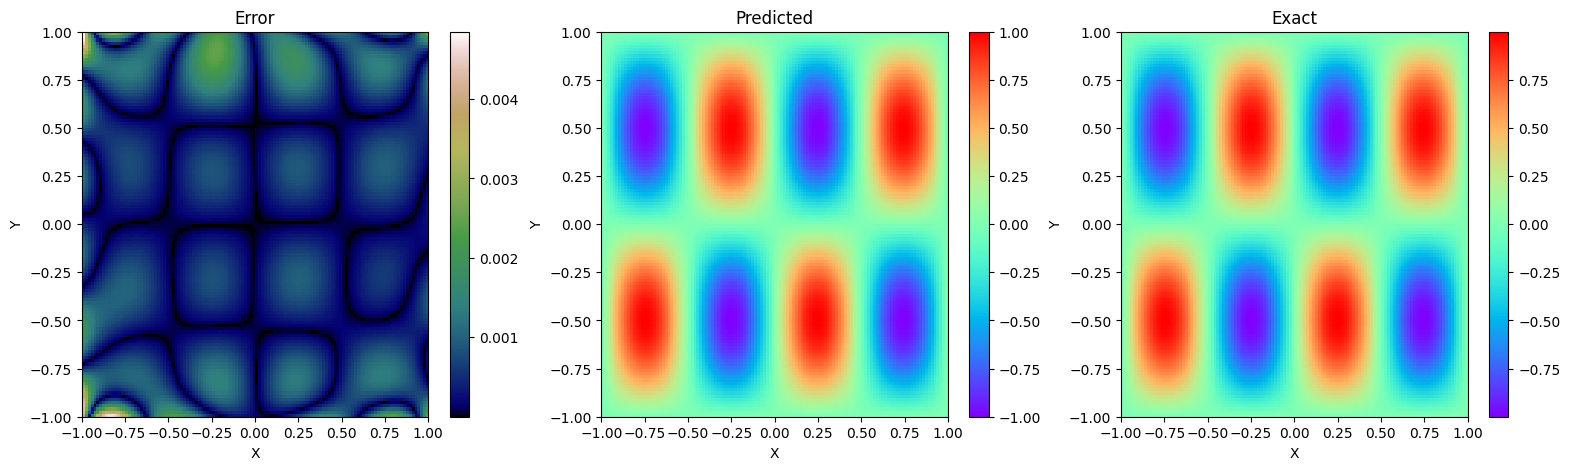

In [23]:
import matplotlib.pyplot as plt
    
outputfile="output.png"    
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(19)

# Plot the Error
ax1 = plt.subplot(1, 3, 1)
shw1 = plt.imshow(Error.reshape((num_test_x, num_test_y)), cmap='gist_earth', interpolation="none", aspect='auto', extent=(x_bound_low, x_bound_up, y_bound_low, y_bound_up))
plt.colorbar(shw1)
plt.xlabel('X')
plt.ylabel('Y')
ax1.set_title("Error")

# Plot the Predicted values for the NN
ax2 = plt.subplot(1, 3, 2)
shw2 = plt.imshow(u_pred.reshape((num_test_x, num_test_y)), cmap='rainbow', interpolation="none", aspect='auto', extent=(x_bound_low, x_bound_up, y_bound_low, y_bound_up))
plt.colorbar(shw2)
plt.xlabel('X')
plt.ylabel('Y')    
ax2.set_title("Predicted")

# Plot the exact solution
plt.subplot(1, 3, 3)
ax3 = plt.subplot(133)
shw3 = plt.imshow(Test_exact.reshape((num_test_x, num_test_y)), cmap='rainbow', interpolation="none", aspect='auto', extent=(x_bound_low, x_bound_up, y_bound_low, y_bound_up))
plt.colorbar(shw3)
plt.xlabel('X')
plt.ylabel('Y')  
ax3.set_title("Exact")

